# Recognize text from slides

## Download slides images from a "totally compliant" website for testing

In [2]:
import requests
try:
    from bs4 import BeautifulSoup
except:
    %pip install beautifulsoup4
    from bs4 import BeautifulSoup

import os


URL_base = "https://www.slideteam.net/in-powerpoint/market-segmentation-dataset-ppt-presentation-templates-and-google-slides"

cwd = os.getcwd()
if not os.path.isdir(os.path.join(cwd,"slides")):
    os.mkdir(os.path.join(cwd,"slides"))

text = requests.get(URL_base).text
soup = BeautifulSoup(text, "html.parser")

def is_pres_sample_link(link):
    return (".html" in link['href'].split("/")[-1] 
                and "ww.slideteam.net" in link['href'].split("/")[-2]
                and not "one-page-summary" in link['href'].split("/")[-1]
                and not "powerpoint-images" in link['href'].split("/")[-1]
                and not "company-profiles.html" in link['href'].split("/")[-1])

links = set()
for link in soup.find_all('a', href=True):
    if is_pres_sample_link(link):
        links.add(link['href'])
counter = 0
imgs_set = set()        # prevent saving different size pictures from different links
for link in links:
    text = requests.get(link).text
    soup = BeautifulSoup(text, "html.parser")
    for item in soup.find_all('img'):
        try:
            img_url = item['src'].replace("330x186","1280x720")
            img_name = img_url.split("/")[-1]
            if "Slide01" in img_name and not img_name in imgs_set:
                print(img_url)
                name_file = "img_slide"+str(counter)
                img_data = requests.get(img_url).content
                with open(cwd+"/slides/"+name_file+".jpg", 'wb') as handler:
                    handler.write(img_data)
                    counter+=1
                imgs_set.add(img_name)
        except:
            continue

https://www.slideteam.net/media/catalog/product/cache/1280x720/0/5/0514_market_segmentation_powerpoint_presentation_Slide01.jpg
https://www.slideteam.net/media/catalog/product/cache/1280x720/m/a/market_segmentation_and_targeting_powerpoint_complete_deck_Slide01_1.jpg
https://www.slideteam.net/media/catalog/product/cache/1280x720/p/r/product_segmentation_markets_and_evaluation_powerpoint_presentation_slides_Slide01.jpg
https://www.slideteam.net/media/catalog/product/cache/1280x720/b/u/business_model_powerpoint_presentation_slides_Slide01.jpg
https://www.slideteam.net/media/catalog/product/cache/1280x720/m/a/market_segmentation_process_steps_powerpoint_presentation_slides_Slide01.jpg
https://www.slideteam.net/media/catalog/product/cache/1280x720/3/d/3d_market_segmentation_powerpoint_template_slide_Slide01.jpg
https://www.slideteam.net/media/catalog/product/cache/1280x720/m/a/marketing_segmentation_startegies_ppt_examples_slides_Slide01.jpg
https://www.slideteam.net/media/catalog/product/

## Recognize title from images

img_slide50.jpg
{'word': ['Market', 'Competitive', 'Attractiveness', 'Economic', 'Segment'], 'lemma': ['market', 'competitive', 'attractiveness', 'economic', 'segment'], '(x,y)': [array([76, 25]), array([332,  24]), array([643,  25]), array([183,  24]), array([509,  24])], '(w,h)': [array([95, 23]), array([163,  30]), array([197,  23]), array([137,  24]), array([125,  31])], 'block_num': [2, 2, 2, 2, 2]}


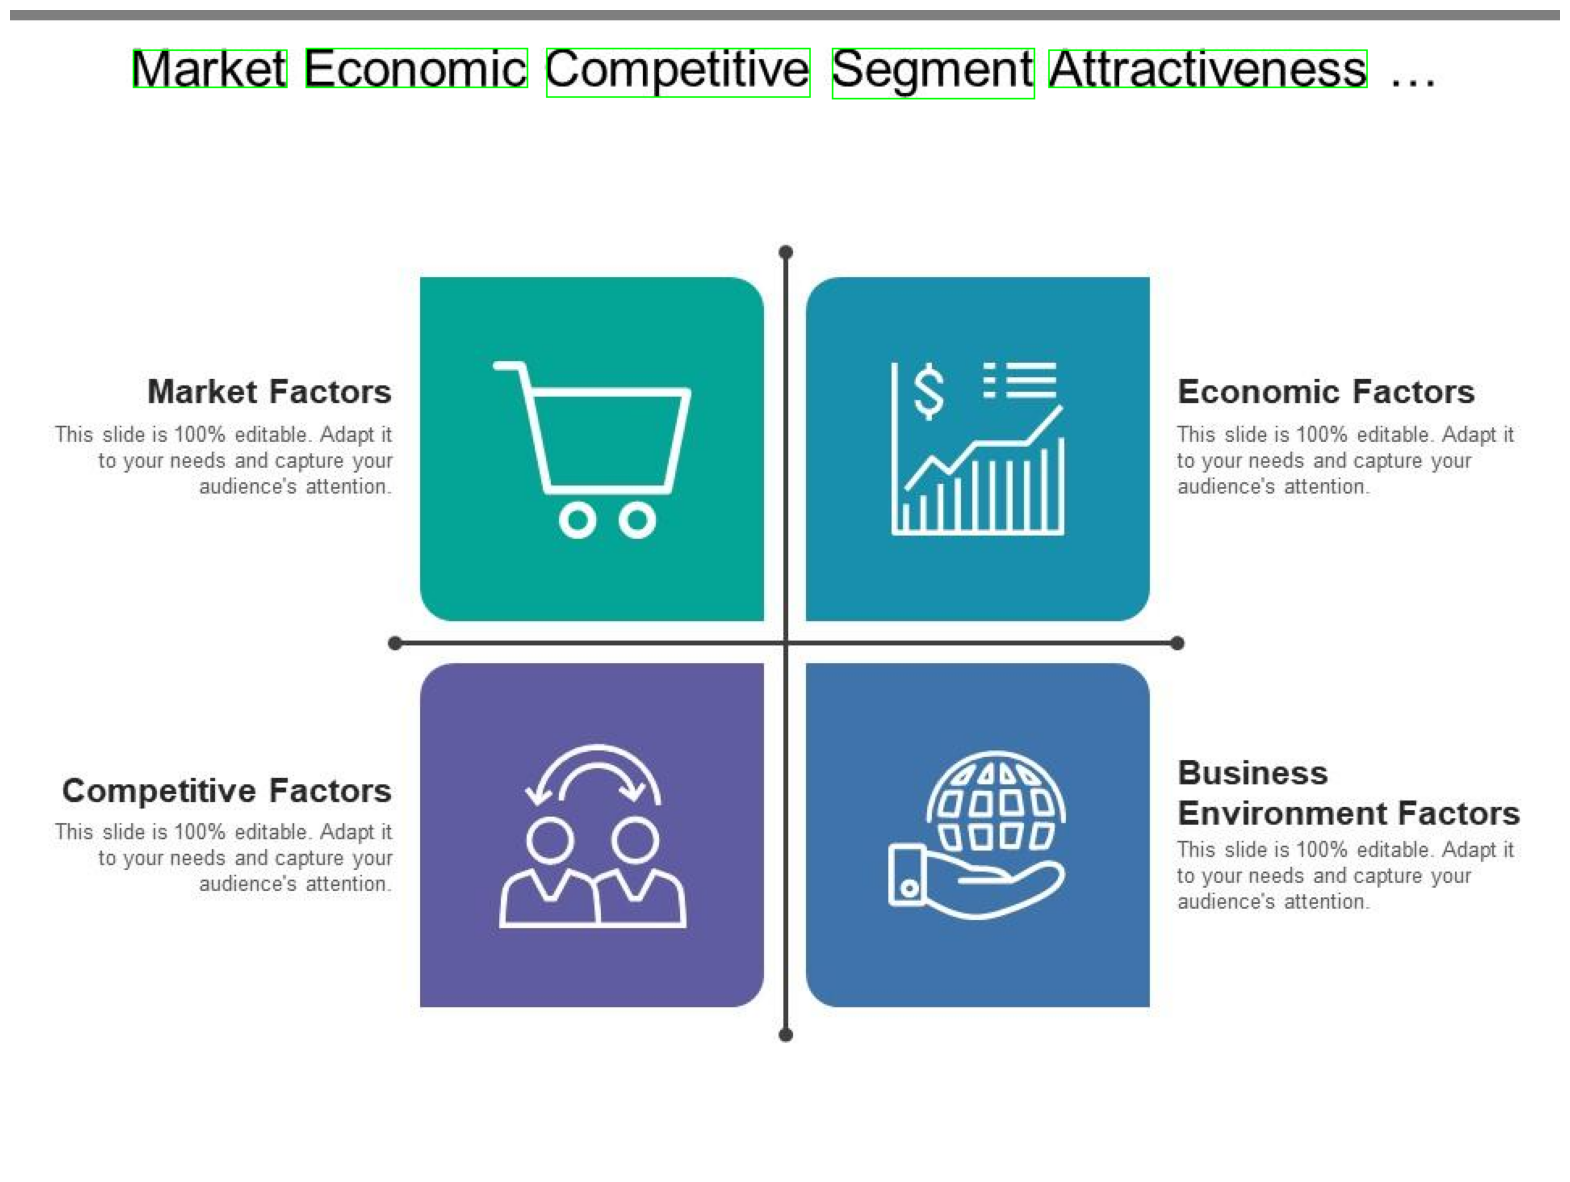

In [51]:
try:
    from pytesseract import pytesseract 
except:
    %pip install pytesseract


try:
    from PIL import Image
except:
    %pip install pillow

# UNUSED
#try:
#    import tesserocr
#except:
#    %pip install tesserocr
#    # in case of error with bd wheels or gcc exit with code 1
#    # sudo apt-get install gcc
#    # sudo apt install build-essential

# may need %pip install opencv-python-headless if opencv-python does not show images
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np

# %pip install nltk
import nltk
# nltk.download('words')
from nltk.corpus import words as words
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from PIL.ImageOps import invert as invImg
from difflib import SequenceMatcher as sm
import io
from random import randint
from string import printable
import re

#import requests
#from bs4 import BeautifulSoup

# TODO OPTIONAL find vocabulary of file formats acronyms
#url = "https://en.wikipedia.org/wiki/List_of_file_formats"
#text = requests.get(url).text
##print(text)
#print(text[text.find("xaml")-30:text.find("xaml")+30])
#soup = BeautifulSoup(text, "html.parser")


# UNUSED
#%pip uninstall -y english-words
#from english_words import english_words_set as words

path_to_images = os.path.join(os.getcwd(),"slides")

#img_name = "img_slide9.jpg"
#img_name = "img_slide22.jpg"
#img_name = "img_slide44.jpg"
#img_name = "img_slide34.jpg"
#img_name = "img_slide38.jpg"
#img_name = "img_slide68.jpg"
#img_name = "img_slide70.jpg"
#img_name = "img_slide104.jpg"
#img_name = "img_slide105.jpg"
#img_name = "img_slide107.jpg"
#img_name = "img_slide110.jpg"
#img_name = "img_slide129.jpg"
#img_name = "img_slide134.jpg"
img_name = "img_slide"+str(randint(0,140))+".jpg"
print(img_name)

# Tesserocr not working -> using tesseract
#with tesserocr.PyTessBaseAPI() as api:
#    image = img
#    api.SetImage(image)
#    api.Recognize()  # required to get result from the next line
#    iterator = api.GetIterator()
#    print(iterator.WordFontAttributes())

pytesseract.tesseract_cmd = r'/usr/bin/tesseract'

def get_meaningless_letters():
    char_set = set(list(printable))
    char_set.discard('a'); char_set.discard('e'); char_set.discard('i'); char_set.discard('o'); char_set.discard('u')
    char_set.discard('0');char_set.discard('1');char_set.discard('2');char_set.discard('3');char_set.discard('4');char_set.discard('5')
    char_set.discard('6');char_set.discard('7');char_set.discard('8');char_set.discard('9')
    return char_set

def binaritize_img(img_path, threshold,flip=False):
    img = invImg(Image.open(img_path).convert("L"))
    if flip:
        img = Image.open(img_path).convert("L")
    orig_pixels_img = np.asarray(img, dtype=np.uint8)
    binarytized_img = np.zeros([img.size[1],img.size[0]],dtype=np.uint8)
    binarytized_img[orig_pixels_img > threshold] = 255
    return binarytized_img

def remove_empty_strings_from_data(data):
    empty_str_indices = [i for i,word in enumerate(data['text']) if len(word.strip())==0]
    for key in data.keys():
        for index in sorted(empty_str_indices, reverse=True):
            data[key].pop(index)
    return data

def get_most_close_word(similar_word, all_words):
    if len(similar_word)==0:
        return ''
    plausible_words = [target_word 
                            for target_word in all_words 
                                if target_word.startswith(similar_word[0]) and target_word.endswith(similar_word[-1:])]

    plausible_words_and_score = [(target_word,sm(None,target_word,similar_word).ratio()) 
                            for target_word in plausible_words 
                                if sm(None,target_word,similar_word).ratio() > 0.8]
    plausible_words_and_score.sort(key=lambda tup: tup[1],reverse=True)
    plausible_words_and_score.append(('',0))
    return plausible_words_and_score[0][0]

def remove_non_alphanum_in_tails(word):
    word_char = list(word)
    word_char[0] = re.sub(r'\W+', '', word[0])
    word_char[-2:] = re.sub(r'\W+', '', word[-2:])
    return ''.join(word_char)

def get_best_words(img,data,wnl,words,min_conf):
    best_words_info = {'word':[],'lemma':[],'(x,y)':[],'(w,h)':[],"block_num":[]}
    for indx, word in enumerate(data['text']):
        if data['conf'][indx] >= min_conf:
            lemma = wnl.lemmatize(remove_non_alphanum_in_tails(word.lower()))
            lemma_in_dictionary = get_most_close_word(lemma, words)
            if lemma_in_dictionary:
                best_words_info['word'].append(word)
                best_words_info['lemma'].append(lemma_in_dictionary)
                (x, y, w, h) = (data['left'][indx], data['top'][indx], data['width'][indx], data['height'][indx])
                best_words_info['(x,y)'].append((x,y))
                best_words_info['(w,h)'].append((w,h))
                best_words_info['block_num'].append(data['block_num'][indx])
    for key in best_words_info.keys():
        best_words_info[key] = np.array(best_words_info[key])
    return best_words_info

def get_title_words(data_words):
    line_heights = np.zeros([data_words['block_num'][-1]+1,1],dtype=np.float64)
    num_words_per_block = np.zeros([data_words['block_num'][-1]+1,1],dtype=np.uint16)
    
    for indx in range(len(data_words['word'])):
        line_heights[data_words['block_num'][indx]] += data_words['(w,h)'][indx][1]
        num_words_per_block[data_words['block_num'][indx]] += 1
    line_heights[line_heights != 0] /= num_words_per_block[num_words_per_block != 0]

    data_title = {}
    for key in data_words.keys():
        data_title[key] = data_words[key][data_words['block_num'] == np.argmax(line_heights)]
    
    return data_title

def is_max_value_betw_similar(value, arr, similar_indexs, indx_max_value=0):
    return all([value[indx_max_value] > elem[indx_max_value] for sim_indx in similar_indexs for (indx,elem) in enumerate(arr) if indx == sim_indx])

def has_similar_2Dpoint(point,array,tol=10):
    return any([x_targ-tol <= point[0] <= x_targ+tol and y_targ-tol <= point[1] <= y_targ+tol for x_targ,y_targ in array])

def get_similar_2Dpoint_indexes(point, array,tol=10):
    return np.where([x_targ-tol <= point[0] <= x_targ+tol and y_targ-tol <= point[1] <= y_targ+tol for x_targ,y_targ in array])[0]

def has_this_2Dpoint(point, array):
    return any([point[0] == x and point[1] == y for x,y in array])

def get_index_of_2Dpoint(point, array):
    return [point[0] == x and point[1] == y for x,y in array].index(True)

def pick_best_xywh(word_arr,xy_arr,wh_arr,h_thresh,d):
    xy_out, wh_out = [],[]
    h_max = 0
    # finding max height of words
    for wh in wh_arr:
        if wh[1] > h_max:
            h_max = wh[1]

    # filtering based on height ratio and picking the largest bounding boxes available
    while len(xy_arr) > 0:
        #word = word_arr.pop()              # TODO if not works, apply minimal height boxes on same words, not necessary for now
        xy, wh = xy_arr.pop(), wh_arr.pop() 

        if wh[1] > h_max*h_thresh and not has_similar_2Dpoint(xy, xy_out):   # if above threshold and not already in the output array
            indexs_similar_points = get_similar_2Dpoint_indexes(xy,xy_arr)
            if len(indexs_similar_points) == 0 or is_max_value_betw_similar(wh,wh_arr,indexs_similar_points):
                xy_out.append(xy), wh_out.append(wh)
    # filtering based on distance of the text with respect to the average words positions' distribution
    eps_var = 20
    distrib = np.zeros([2,2])
    n = len(xy_out)
    
    for xy in xy_out:
        distrib[0,:] += xy/n
        distrib[1,:] += (xy**2)/n
    distrib[1,:] -= distrib[0,:]**2
    distrib[1,:] = np.sqrt(np.abs(distrib[1,:].round(decimals=2)))
    
    if distrib[1,1] < eps_var:
        distrib[1,1] = 40
    for indx in reversed(range(len(xy_out))):
        if xy_out[indx][0] < distrib[0,0] - distrib[1,0]*d or xy_out[indx][0] > distrib[0,0] + distrib[1,0]*d \
                or xy_out[indx][1] < distrib[0,1] - distrib[1,1]*d or xy_out[indx][1] > distrib[0,1] + distrib[1,1]*d : # if in one of the 4 tails remove the element
            xy_out.pop(indx), wh_out.pop(indx)

    return xy_out,wh_out

def fill_xywh_fields(from_dict,to_dict,xy_arr,wh_arr):  # TODO can be optimized inverting the loops
    while len(xy_arr) > 0:
        xy = xy_arr.pop()
        wh = wh_arr.pop()
        for img_transf in from_dict.keys():
            if has_this_2Dpoint(xy,from_dict[img_transf]['(x,y)']) and has_this_2Dpoint(wh,from_dict[img_transf]['(w,h)']): # match on elements in the data structure based on xywh 
                indx = get_index_of_2Dpoint(xy,from_dict[img_transf]['(x,y)'])               
                for info_kind in from_dict[img_transf].keys():
                    to_dict[info_kind].append(from_dict[img_transf][info_kind][indx])
                break
    return to_dict

def merge_title_words_of_all_images(title_words_img,text_height_ratio_threshold,max_dispersion):

    xy = [  title_words_img[source]['(x,y)'][j] 
            for source in title_words_img.keys() 
            for j in range(len(title_words_img[source]['(x,y)'])) ]
    wh = [  title_words_img[source]['(w,h)'][j]
            for source in title_words_img.keys() 
            for j in range(len(title_words_img[source]['(x,y)'])) ]
    #word = [title_words_img[source]['word'][j] 
    #        for source in title_words_img.keys() 
    #        for j in range(len(title_words_img[source]['(x,y)']))]

    xy,wh = pick_best_xywh(
                            #word
                            None,
                            xy,
                            wh,
                            text_height_ratio_threshold,
                            max_dispersion
                            )

    title = {info:[] for info in title_words_img[list(title_words_img.keys())[0]].keys()}

    return fill_xywh_fields(title_words_img,title,xy,wh)

def clean_dupes_from_title(title_words):
    seen_words = set()
    dupe_indexes = [indx for indx,word in enumerate(title_words['word']) if word in seen_words or seen_words.add(word)]
    for key in title_words.keys():
        for dupe_indx in dupe_indexes:
            title_words[key].pop(dupe_indx)
    return title_words
        
def get_title_from_img(img_path,binarization_threshold=120,min_classification_confidence=80,text_height_ratio_threshold=0.6,max_dispersion=2):

    """
    Gives the title words from an image by extracting it with pytesseract from the original, the binarized and the color-inverted version\n
        1) Data returned by pytesseract analysis for every image is cleaned from empty strings. (remove_empty_strings)\n
        2) Filtering based on classification confidence and a dictionary from wordnet (get_best_words)
            \t\tFurther optimizations: (search can be improved by using a tree to map the wordnet words)\n
        3) Aggregation based on num_block parameter provided by pytesseract and picked the text with max height (get_title_words)\n
        4) Results from the sources is merged based on the text height and position

    Arguments:
        img_path:                       the path of the image
        binarization_threshold:         when converting the image to grayscale,pixel value threshold is applied to make the pixel white or black
                                        values above threshold are white, otherwise are black
        min_classification_confidence:  threshold of classification confidence given by pytesseract
        text_height_ratio_threshold:    when filtering based on text height every element is compared to the tallest
                                        if elem < max * threshold it is discarded because it's too small with respect to the title
        max_dispersion:                 statistical analysis on text average position, this parameter states how many std deviations 
                                        from the mean are considered
    Returns:
        title words dictionary that contains:\n
            word recognized\n
            lemma it comes from\n
            x,y position of every word's bounding boxes in the image\n
            width, height of bounding boxes\n
            block_num recognized (not to trust)
    """

    assert(0 < binarization_threshold < 255 and min_classification_confidence < 100 and 0 < text_height_ratio_threshold < 1 and max_dispersion >= 0)
    img = cv2.imread(img_path)
    assert img is not None, "img path is invalid"
    # standard image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # binairtized with the threshold
    img_binaritized = binaritize_img(img_path,threshold=binarization_threshold) # binarization increases recognition performances
    # original with flipped bits
    img_flipped = cv2.bitwise_not(img)
    # binaritized with threshold halfed
    img_binaritized_half_thresh = binaritize_img(img_path,binarization_threshold/2)

    transformations = ['original','binarized','flipped','binaritized_half']
    images = [img,img_binaritized,img_flipped,img_binaritized_half_thresh]

    data_img = {}

    for indx,transf in enumerate(transformations):
        data_img[transf] = remove_empty_strings_from_data(pytesseract.image_to_data(images[indx], output_type='dict'))

    wnl = WordNetLemmatizer()
    all_words = set(wn.words()).union(set(words.words()))
    all_words.difference_update(get_meaningless_letters())
    #all_words = sorted(all_words)                           # TODO enlarge the dictionary with other words and manage them differently (maybe with a tree search or a library)

    best_words_info_img = {}

    for indx,transf in enumerate(transformations):
        best_words_info_img[transf] = get_best_words(images[indx],data_img[transf],wnl,all_words,min_conf=min_classification_confidence)

    for indx,transf in sorted(enumerate(transformations),reverse=True):
        if len(best_words_info_img[transf]['word']) == 0:
            best_words_info_img.pop(transf)
            transformations.pop(indx)
            images.pop(indx)

    if len(transformations)==0:
        raise Exception("Cannot recognize any text in the current image")

    title_words_img = {}

    for transf in transformations:
        title_words_img[transf] = get_title_words(best_words_info_img[transf])
    
    # Testing recognition at different steps
    #dict_imc = data_img
    #dict_img = best_words_info_img
    #dict_img = title_words_img
    #for indx,key in enumerate(dict_img.keys()):
    #    for i in range(len(dict_img[key]['word'])):
    #        (x,y,w,h) = (dict_img[key]['(x,y)'][i][0],dict_img[key]['(x,y)'][i][1],dict_img[key]['(w,h)'][i][0],dict_img[key]['(w,h)'][i][1])
    #        if i == 0:
    #            img = images[indx]
    #        img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 1)
    #    print(transformations[indx])
    #    plt.figure(figsize=(20,20))
    #    plt.axis('off')
    #    plt.imshow(img)

    title_words = merge_title_words_of_all_images(title_words_img,text_height_ratio_threshold,max_dispersion)

    return clean_dupes_from_title(title_words)

#img = cv2.cvtColor(cv2.imread(path_to_images+"/"+img_name), cv2.COLOR_BGR2RGB)
#plt.figure(figsize=(20,20))
#plt.axis('off')
#plt.imshow(img)
title_words_info = get_title_from_img(path_to_images+"/"+img_name)
print(title_words_info)
#print(title_words_info)
img = cv2.cvtColor(cv2.imread(path_to_images+"/"+img_name), cv2.COLOR_BGR2RGB)
for indx,(x,y) in enumerate(title_words_info['(x,y)']):
    img = cv2.rectangle(img, (x, y), (x + title_words_info['(w,h)'][indx][0], y + title_words_info['(w,h)'][indx][1]), (0, 255, 0), 1)
plt.figure(figsize=(20,20))
plt.axis('off')
plt.imshow(img)